In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import sys
import itertools
from gurobipy import *
import networkx as nx

# Calculating the distance matrix for cities of Qatar

In [2]:
# load the text file
cities = pd.read_csv("/Users/assanakbota/Desktop/HW2_qatar_tsp.txt", engine = 'python',  
                     skipfooter = 1, skiprows = 7, index_col = 0, header = None, sep = ' ')
cor = []
loc = {}
with open("/Users/assanakbota/Desktop/HW2_qatar_tsp.txt", "r") as f:
    [cor.append(x.split()) for i, x in enumerate(f) if 7 <= i]
for i in range(194):
    loc[i] = (float(cor[i][1])/1000), (float(cor[i][2])/1000)

In [3]:
# the values have been mutiplied by a thousand, so we are going to return it back to standard form

for i in range(1, len(cities) + 1):
    cities[1][i] = cities[1][i]/1000
    cities[2][i] = cities[2][i]/1000
    
# distance calculator from John Cook's Conulsting website link

def distance_on_unit_sphere(lat1, long1, lat2, long2):

    degrees_to_radians = math.pi/180.0
 
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
 
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians 
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + math.cos(phi1)*math.cos(phi2))
    arc = math.acos(cos)
    
    # mulitplying it by the radius of the Earth in km
    arc = arc*6371
    return arc

In [4]:
# calculating distances between all cities
distances = []
for i in range(1, len(cities) + 1):
    for k in range(1, len(cities) + 1):
        if i != k:
            distances.append(distance_on_unit_sphere(cities[1][i], cities[2][i], cities[1][k], cities[2][k]))
        elif i == k:
            distances.append(0)

# Plotting cities of Qatar as scatter plot 

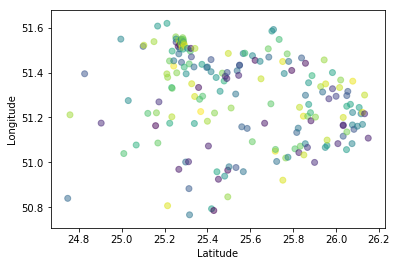

<Figure size 1080x1080 with 0 Axes>

In [5]:
# reshaping the distances array into distance matrix
distances_matrix = np.reshape(distances, (194, 194))


#plotting the cities as a scatter plot
colors = np.random.rand(194)
plt.scatter(cities[1], cities[2], c = colors, alpha=0.5)
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.figure(figsize = (15,15))
plt.show()

# Constructing the raw optimization problem with constraints equal to 2

In [6]:
m = Model("qatar_travel")

#setting variables
edges = {}
for i in range(194):
    for j in range(194):
        edges[i,j] = m.addVar(vtype=GRB.BINARY, name = "e")
        edges[j,i] = edges[i,j]
        edges[i,i] = 0
    m.update()

Academic license - for non-commercial use only


In [7]:
#setting the objective function
obj = 0.0
for i in range(194):
    for j in range(i+1):
        obj += distances_matrix[i, j]*edges[i,j]
m.update()

In [8]:
# setting constraints
for i in range(194):
    total_c = 0
    for j in range(194):

        total_c += edges[i,j] 
    m.addConstr(total_c == 2)
    m.update()

In [9]:
#optimization
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

Optimize a model with 194 rows, 37636 columns and 37442 nonzeros
Variable types: 0 continuous, 37636 integer (37636 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 9433.4756272
Presolve removed 0 rows and 18915 columns
Presolve time: 0.04s
Presolved: 194 rows, 18721 columns, 37442 nonzeros
Variable types: 0 continuous, 18721 integer (18721 binary)

Root relaxation: objective 9.483598e+02, 301 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  948.35982    0   40 9433.47563  948.35982  89.9%     -    0s
H    0     0                    1098.3523268  948.35982  13.7%     -    0s
H    0     0                     957.2368925  948.35982  0.93%     -    0s
     0     0  952.86604    0   30  957.23689  

/Users/junbotang/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


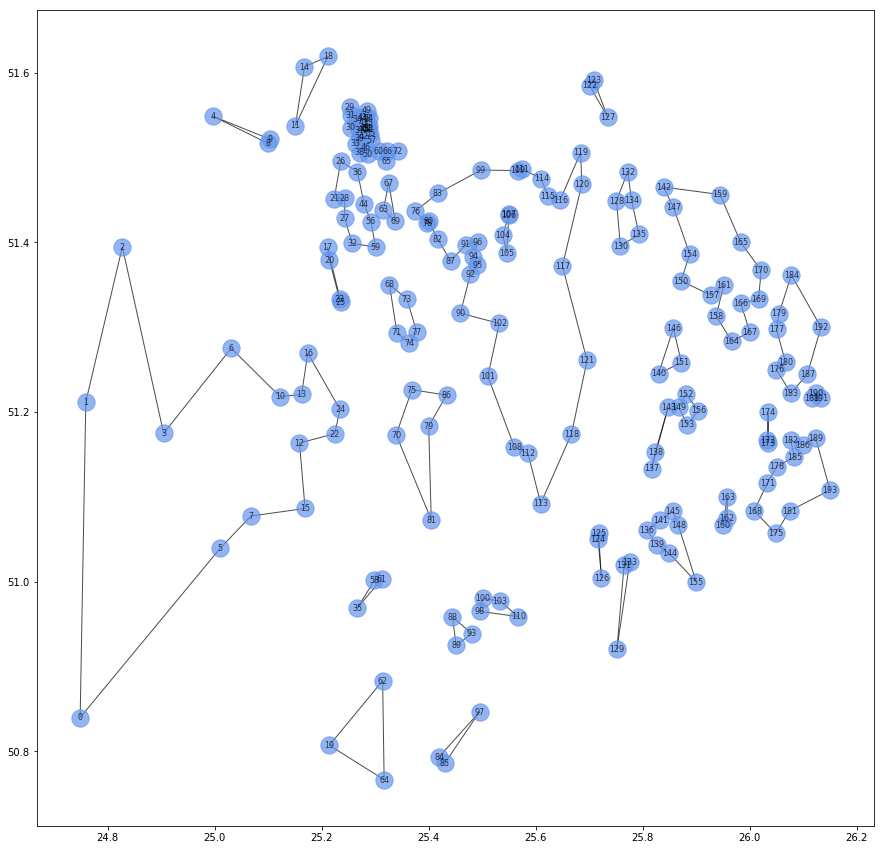

In [10]:
# Retrieve edges' incidence info to plot a adjacency matrix 
solutions = {}
edges_names = []
for v in m.getVars():
    solutions[v.varName] = v.x
    edges_names += [v.x]
emax = np.reshape(edges_names,(194,194))
emax = np.array(emax)

# Plot a graph that represents cities' geographical info and edges that connect them
G = nx.from_numpy_matrix(emax, parallel_edges=False, create_using=None)
plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=loc, with_labels=True, node_size = 300, 
                 font_size = 8, alpha = 0.7, node_color = 'cornflowerblue')

#  Devising a subtour finder that allows us to identify subtours 
#  Devising a cut finder that allows us to identify a cut between a subtour and all other nodes/subtours
#  Devising a contraint adder that allows us to add a constraint to eliminate a cut
#  Repeating the process for subtours that originated from node 0 and 19 as demonstrated below

In [11]:
# finds all nodes that are connected between each other in a form of a path finds
# it takes a node that is in a subtour and finds all  other nodes that are within the same subtour
def sub_tour_finder(start_node):
    explored = [start_node]
    all_nodes = [start_node]
    while explored != []:
        for k in G.neighbors(explored[0]):
        # 3,5 
            if k not in set(all_nodes):
                explored.append(k)
                all_nodes.append(k)
            
        explored.pop(0)
    return all_nodes

In [12]:
# finds all edges that are not connected to a subtour within a given subtour

def cut_edge_finder(nodes):
    c_edges = []
    for i in nodes:
        for k in range(194):
            if k not in G.neighbors(i):
                if k not in nodes and  i!=k:
                    c_edges.append([i, k])
    return c_edges
        

We can visually see that node 0 is present in a subtour. We plug node zero into our subtour finder to find all other nodes that are present in the same subtour with node 0. We then find all cuts between a subtour with node 0 and all other nodes/subtours. 

In [13]:

s1 = sub_tour_finder(0)
c1 = cut_edge_finder(s1)
print(s1)
print(c1)

[0, 1, 5, 2, 7, 3, 15, 6, 12, 10, 22, 13, 24, 16]
[[0, 4], [0, 8], [0, 9], [0, 11], [0, 14], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 23], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [0, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [0, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [0, 54], [0, 55], [0, 56], [0, 57], [0, 58], [0, 59], [0, 60], [0, 61], [0, 62], [0, 63], [0, 64], [0, 65], [0, 66], [0, 67], [0, 68], [0, 69], [0, 70], [0, 71], [0, 72], [0, 73], [0, 74], [0, 75], [0, 76], [0, 77], [0, 78], [0, 79], [0, 80], [0, 81], [0, 82], [0, 83], [0, 84], [0, 85], [0, 86], [0, 87], [0, 88], [0, 89], [0, 90], [0, 91], [0, 92], [0, 93], [0, 94], [0, 95], [0, 96], [0, 97], [0, 98], [0, 99], [0, 100], [0, 101], [0, 102], [0, 103], [0, 104], [0, 105], [0, 106], [0, 107], [0, 108], [0, 109], [0, 110], [0, 111], [0, 112], [0, 113], [0, 114], [0, 115], [0, 116], [0, 117]

In [14]:
# adds a constraint with all cuts to elimiate subtours
def add_constr(c):
    constr = 0
    for i in range(len(c)):
        constr += edges[c[i][0], c[i][1]]
    m.addConstr(constr >= 2)
    m.update()

Let's optimize our current model with a constraint that contains all the cuts.

In [15]:
add_constr(c1)
m.optimize()

Optimize a model with 195 rows, 37636 columns and 39962 nonzeros
Variable types: 0 continuous, 37636 integer (37636 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]

MIP start did not produce a new incumbent solution
MIP start violates constraint R194 by 2.000000000

Found heuristic solution: objective 9433.4756272
Presolve removed 0 rows and 18915 columns
Presolve time: 0.04s
Presolved: 195 rows, 18721 columns, 39962 nonzeros
Variable types: 0 continuous, 18721 integer (18721 binary)

Root relaxation: objective 9.497734e+02, 310 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  949.77339    0   40 9433.47563  949.77339  89.9%     -    0s
H    0     0                    1109.5998843  949.77339  14.4%     -    0s
H    0     0      

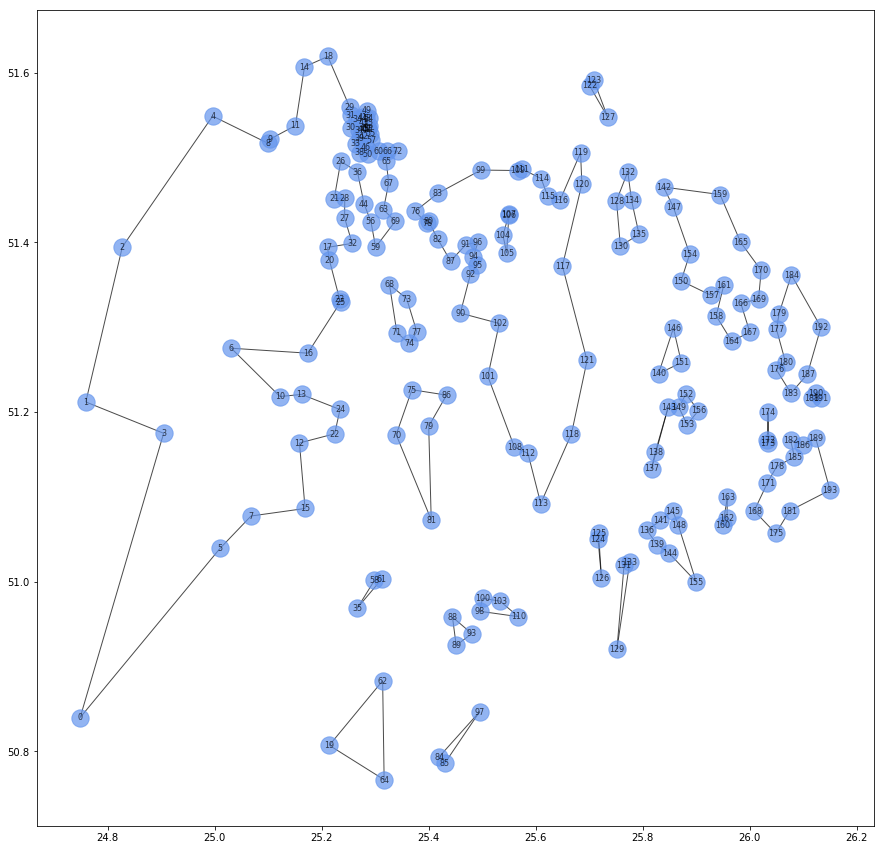

In [16]:
solutions = {}
edges_names = []
for v in m.getVars():
    solutions[v.varName] = v.x
    edges_names += [v.x]
emax = np.reshape(edges_names,(194,194))
emax = np.array(emax)

# Plot a graph that represents cities' geographical info and edges that connect them
G = nx.from_numpy_matrix(emax, parallel_edges=False, create_using=None)
plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=loc, with_labels=True, node_size = 300, 
                 font_size = 8, alpha = 0.7, node_color = 'cornflowerblue')

We repeat the process again. Let's focus on a subtour that contains node 19. 

In [17]:
s2 =  sub_tour_finder(19)
c2 = cut_edge_finder(s2)

In [18]:
add_constr(c2)
m.optimize()

Optimize a model with 196 rows, 37636 columns and 40535 nonzeros
Variable types: 0 continuous, 37636 integer (37636 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]

MIP start did not produce a new incumbent solution
MIP start violates constraint R195 by 2.000000000

Found heuristic solution: objective 9433.4756272
Presolve removed 0 rows and 18915 columns
Presolve time: 0.05s
Presolved: 196 rows, 18721 columns, 40535 nonzeros
Variable types: 0 continuous, 18721 integer (18721 binary)

Root relaxation: objective 9.545186e+02, 294 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  954.51862    0   48 9433.47563  954.51862  89.9%     -    0s
H    0     0                    1075.2179082  954.51862  11.2%     -    0s
H    0     0      

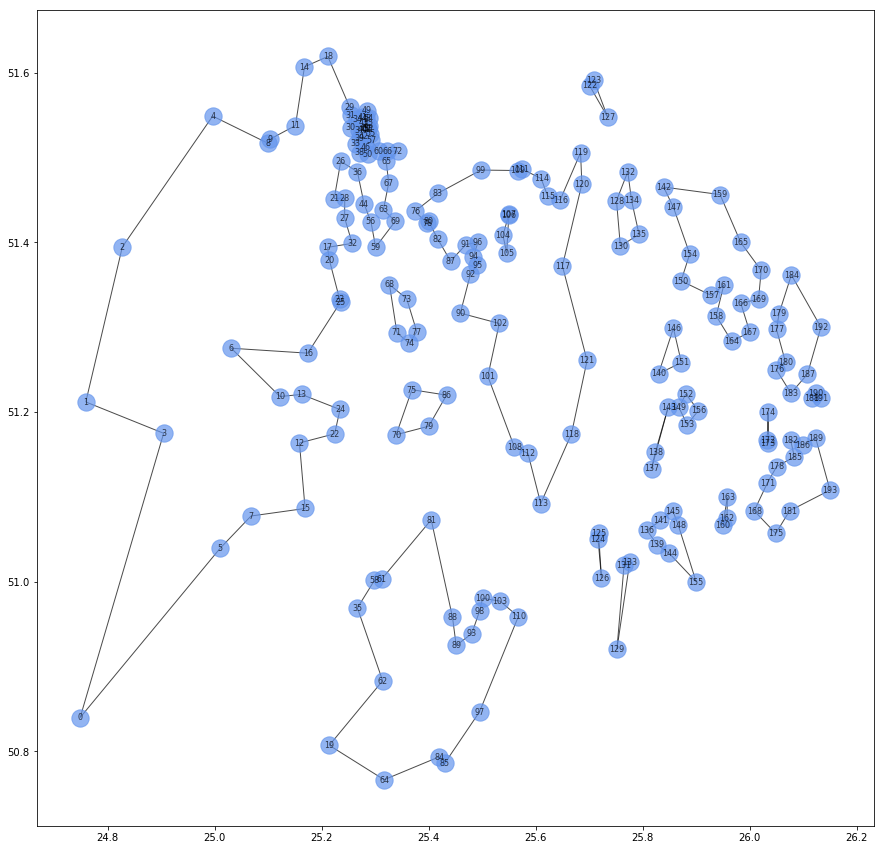

In [19]:
solutions = {}
edges_names = []
for v in m.getVars():
    solutions[v.varName] = v.x
    edges_names += [v.x]
emax = np.reshape(edges_names,(194,194))
emax = np.array(emax)

# Plot a graph that represents cities' geographical info and edges that connect them
G = nx.from_numpy_matrix(emax, parallel_edges=False, create_using=None)
plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=loc, with_labels=True, node_size = 300, 
                 font_size = 8, alpha = 0.7, node_color = 'cornflowerblue')

We can already see the incremental improvements of our model. 
If we repeat the process for every subtour, just like we did for subtours that originated from node 0 and 19, we'll eventually have the optimal model (this might take thousands and thousands of subtour eliminations).

#  The following code generates the optimal model. The codes are partly taken from the documentation of Gurobi
#  The resulted best objective is 992km

In [20]:
# reshaping the distances array into distance matrix
distances_matrix = np.reshape(distances, (194, 194))
distances_matrix = pd.DataFrame(distances_matrix)
distdic = distances_matrix.to_dict()
dist = {}
for i in range(194):
    for j in range(194):
        dist[i,j] = distdic[i][j]
        
# Create model and variables 

m = Model("qatar_travel")
vars = {}
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')
for i,j in vars.keys():
    vars[j,i] = vars[i,j]
    m.update()

In [21]:
# setting constraints
for i in range(194):
    total_c = 0
    for j in range(194):

        total_c += vars[i,j] 
    m.addConstr(total_c == 2)
    vars[i,i].ub = 0
    m.update()

In [22]:
# subtour elimination (method from official Gurobi documentation)
def subtourelim(model, where): 
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = tuplelist((i,j) for i,j in model._vars.keys() if vals[i,j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < 194:
            # add subtour elimination constraint for every pair of cities in tour
            model.cbLazy(quicksum(model._vars[i,j]
                                  for i,j in itertools.combinations(tour, 2))
                         <= len(tour)-1)

In [23]:
# find the shortest subtour given a list of edges (method from official Gurobi documentation)
def subtour(edges):
    unvisited = list(range(194))
    cycle = range(194+1) # initial length has 1 more city
    while unvisited: # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i,j in edges.select(current,'*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [24]:
#optimization
m._vars = vars
m.params.LazyConstraints = 1
m.optimize(subtourelim)

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 194 rows, 37636 columns and 37636 nonzeros
Variable types: 0 continuous, 37636 integer (37636 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 0 rows and 194 columns
Presolve time: 0.04s
Presolved: 194 rows, 37442 columns, 37442 nonzeros
Variable types: 0 continuous, 37442 integer (37442 binary)

Root relaxation: objective 9.483598e+02, 306 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  948.35982    0   40          -  948.35982      -     -    0s
     0     0  957.61127    0   38          -  957.61127      -     -    0s
     0     0  959.55057    0   24          -  959.55057      -     -    0s
     0    

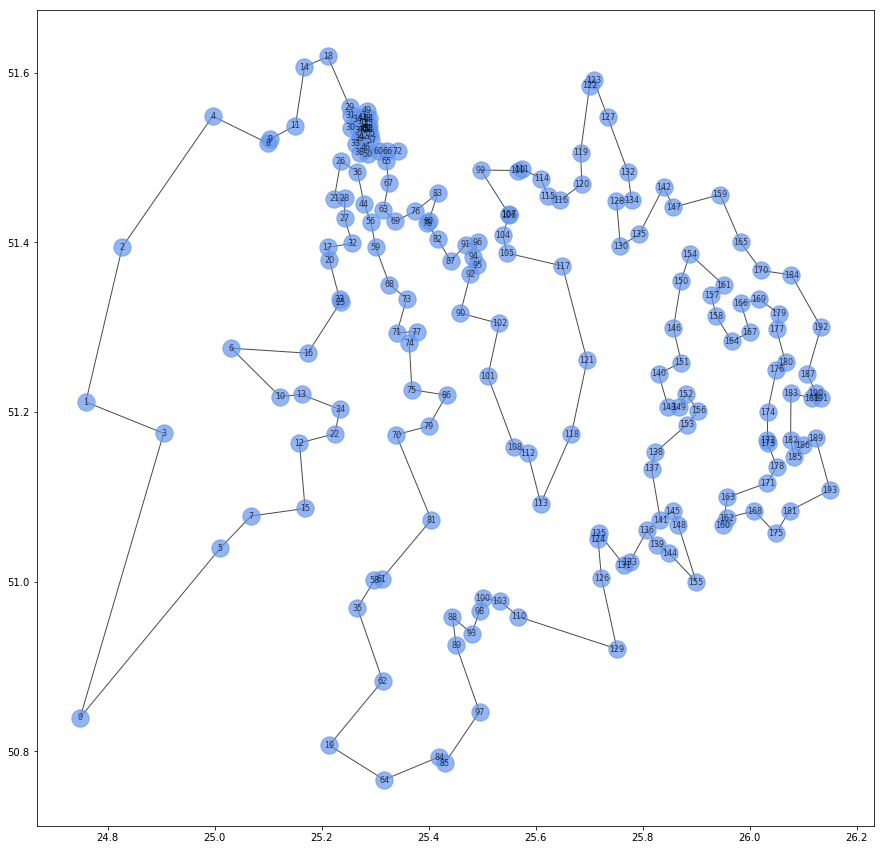

In [25]:
# Retrieve edges' incidence info to plot a adjacency matrix 
solutions = {}
edges_names = []
for v in m.getVars():
    solutions[v.varName] = v.x
    edges_names += [v.x]
emax = np.reshape(edges_names,(194,194))
emax = np.array(emax)

# Plot a graph that represents cities' geographical info and edges that connect them
G = nx.from_numpy_matrix(emax, parallel_edges=False, create_using=None)
plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos=loc, with_labels=True, node_size = 300, 
                 font_size = 8, alpha = 0.7, node_color = 'cornflowerblue')